# Spatially-Resolved Mass-Metallicity Relation

We're going to construct the spatially-resolved mass-metallicity relation (MZR) for a MaNGA galaxy, where mass refers to stellar mass and metallicity refers to gas-phase oxygen abundance.

### Roadmap
1. Compute metallicity.
2. Select spaxels that are
  1. star-forming, 
  2. not flagged as "bad data," and
  3. above a signal-to-noise ratio threshold.
3. Compute stellar mass surface density.
4. Plot metallicity as a function of stellar mass surface density.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
from os.path import join
path_notebooks = os.path.abspath('.')
path_data = join(path_notebooks, 'data')

## Load Maps for Galaxy

Import the Marvin `Maps` class from `marvin.tools.maps` and initialize a `Maps` object for the galaxy 8077-6104.

INFO: No release version set. Setting default to MPL-6


## Measure Metallicity


### Pettini & Pagel (2004) N2 metallicity calibration

We are going to use the N2 metallicity calibration (their Equation 1) from Pettini & Pagel (2004):

12 + log(O/H) = 8.90 + 0.57 $\times$ log( $\frac{F([NII])}{F(H\alpha)}$ ).

One of the benefits of this calibration is that the required lines are very close in wavelength, so the reddening correction is negligible.

Get [NII] 6585 and Halpha flux maps from the Marvin `Maps` object.  Note: MaNGA (and Marvin) use the wavelengths of lines in vaccuum, whereas they are usually reported in air, hence the slight offsets.

Calculate the necessary line ratio.

Marvin can do map arithmetic, which propagates the inverse variances and masks, so you can just do `+`, `-`, `*`, `/`, and `**` operations as normal.  (Note: taking the log of a Marvin `Map` will work for the values but the inverse variance propagation does not correctly propagate the inverse variance yet.)

Finally, calculate the metallicity.

## Select Spaxels
### Using the BPT Diagram to select star-forming spaxels

Metallicity indicators only work for star-forming spaxels, so we need a way to select only these spaxels.

The classic diagnostic diagram for classify the emission from galaxies (or galactic sub-regions) as star-forming or non-star-forming (i.e., from active galactic nuclei (AGN) or evolved stars) was originally proposed in Baldwin, Phillips, & Terlevich (1981) and is known as the **BPT diagram**.

The BPT diagram uses ratios of emission lines to separate thermal and non-thermal emission.

The classic BPT diagram uses [OIII]5007 / Hbeta vs. [NII]6583 / Halpha, but there are several versions of the BPT diagram that use different lines ratios.

### BPT Diagrams with Marvin

Let's use Marvin's `maps.get_bpt()` method to make BPT diagrams for this galaxy.

**red line**: maximal starbust (Kewley et al 2001) -- everything to the right is non-star-forming.  
**dashed black line**: conservative star-forming cut (Kauffmann et al. 2003) -- everything to the left is star-forming.

Line ratios that fall in between these two lines are designated "Composite" with contributions from both star-forming and non-star-forming emission.

**blue line**: separates non-star-forming spaxels into Seyferts and LINERs.

Seyferts are a type of AGNs.

LINERs (Low Ionization Nuclear Emission Regions) are not always nuclear (LIER is a better acronym) and not always AGN (oftern hot evolved stars).

Sometimes these diagnostic diagrams disagree with each other, hence the "Ambiguous" designation.

Try using `maps.get_bpt?` to read the documentation on how to use this function.

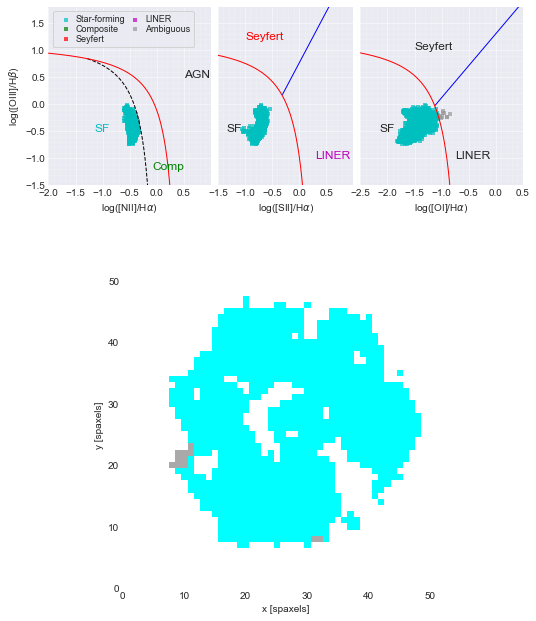

The BPT masks are dictionaries of dictionaries of a boolean (True/False) arrays.  We are interested in the spaxels that are classified as star-forming in all three BPT diagrams are designated as ``True``, which is designated with the `global` key.  Print this mask.

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### Masks
MaNGA (and SDSS generally) use bitmasks to communicate data quality.

Marvin has built-in methods to convert from the bitmasks integer values to individual bits or labels and to create new masks by specifying a set of labels.

Show the mask schema with `n2.pixmask.schema`.

,bit,label,description
0,0,NOCOV,No coverage in this spaxel
1,1,LOWCOV,Low coverage in this spaxel
2,2,DEADFIBER,Major contributing fiber is dead
3,3,FORESTAR,Foreground star
4,4,NOVALUE,Spaxel was not fit because it did not meet sel...
5,5,UNRELIABLE,Value is deemed unreliable; see TRM for defini...
6,6,MATHERROR,Mathematical error in computing value
7,7,FITFAILED,Attempted fit for property failed
8,8,NEARBOUND,Fitted value is too near an imposed boundary; ...
9,9,NOCORRECTION,Appropriate correction not available


Select non-star-forming spaxels (from the BPT mask) and set their mask value to the DAP's DONOTUSE value with the `n2.pixmask.labels_to_value()` method.  Note that we are selecting spaxels that we want from the BPT mask (i.e., `True` is a spaxel to keep), whereas we are using the pixmask to select spaxels that we want to exclude (i.e., `True` is a spaxel to ignore).

Select spaxels classified by the DAP as bad data according to the masks for spaxels with no IFU coverage, with unreliable measurements, or otherwise unfit for science.  Use the `n2.pixmask.get_mask` method.

Select spaxels with signal-to-noise ratios (SNRs) > 3 on both [NII] 6585 and Halpha.

`ha.ivar` = inverse variance = $\frac{1}{\sigma^2}$, where $\sigma$ is the error.

Do a [bitwise (binary) OR](https://www.tutorialspoint.com/python/bitwise_operators_example.htm) to create a master mask of spaxels to ignore.

## Plot the Metallicity Map

Plot the map of metallicity using the `plot()` method from your Marvin `Map` metallicity object.  Also, mask undesirable spaxels and label the colorbar.

Note: solar metallicity is about 8.7.

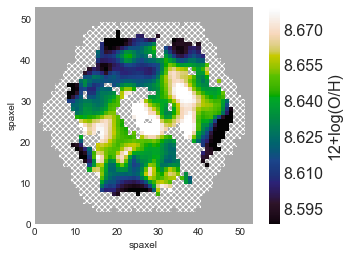

## Compute Stellar Mass Surface Density

1. Read in spaxel stellar mass measurements from the Firefly spectral fitting catalog (Goddard et al. 2017).
  - The [Firefly stellar population fitting results file](https://data.sdss.org/sas/dr14/manga/spectro/firefly/v1_0_3/manga_firefly-v2_1_2-STELLARPOP.fits) is large (1.8 GB), so we have extracted only the measurements needed for our purposes [DOWNLOAD CSV FILE](https://sdss-marvin.readthedocs.io/en/latest/tutorials/exercises/data/manga-8077-6104_mstar.csv).
  - [Summary of the Firefly Value Added Catalog](http://www.sdss.org/dr14/manga/manga-data/manga-firefly-value-added-catalog/)
  - [Datamodel of the Firefly Value Added Catalog](https://data.sdss.org/datamodel/files/MANGA_FIREFLY/FIREFLY_VER/manga_firefly-STELLARPOP.html)
2. Convert spaxel angular size to a physical scale in pc.
3. Divide stellar mass by area to get stellar surface mass density.

### Read in stellar masses

Use [pandas](http://pandas.pydata.org/pandas-docs/stable/) to read in the csv file with stellar masses.

In [15]:
import pandas as pd
mstar = pd.read_csv(join(path_data, 'manga-{}_mstar.csv'.format(maps.plateifu)))

Plot stellar mass map using `ax.imshow()`.  MaNGA maps are oriented such that you want to specify `origin='lower'`.  Also include a labelled colorbar.

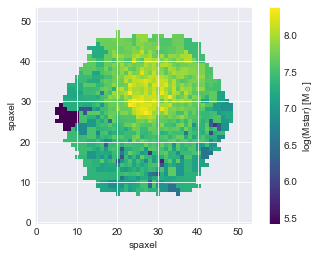

### Calculate physical size of a spaxel

MaNGA's maps (and data cubes) have a spaxel size of 0.5 arcsec. Let's convert that into a physical scale for our galaxy.

Get the redshift of the galaxy from the `maps.nsa` attribute.

We'll use the **small angle approximation** to estimate the physical scale:

$\theta = \mathrm{tan}^{-1}(\frac{d}{D}) \approx \frac{206,265 \, \mathrm{arcsec}}{1 \, \mathrm{radian}} \frac{d}{D}$,

where  
$\theta$ is the angular size of the object (in our case spaxel) in arcsec,  
$d$ is the diameter of the object (spaxel), and  
$D$ is the angular diameter distance.


The distance (via the **Hubble Law** --- which is fairly accurate for low redshift objects) is

$D \approx \frac{cz}{H_0}$,

where  
$c$ is the speed of light in km/s,  
$z$ is the redshift, and  
$H_0$ is the Hubble constant in km/s/Mpc.

Calculate $D$.

Rearrange the small angle formula to solve for the scale ($\frac{d}{\theta}$) in pc / arcsec.

Now convert the spaxel size from arcsec to parsecs and calculate the area of a spaxel.

Finally, we simply divide the stellar mass by the area to get the stellar mass surface density $\Sigma_\star$ in units of $\frac{M_\odot}{pc^2}$.

Let's plot metallicity as a function of $\Sigma_\star$!  Remember to apply the mask.  Also set the axis range to be `[0, 4, 8, 8.8]`.

[0, 4, 8.0, 8.8]

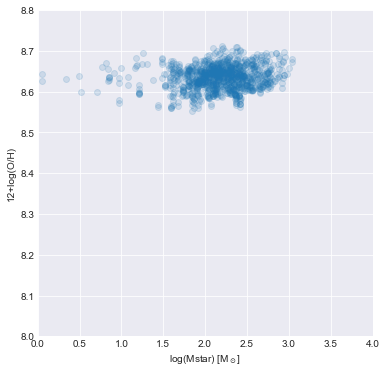

### MaNGA Spatially-Resolved Mass-Metallicity Relation

We have constructed the spatially-resolved MZR for one galaxy, but we are interested in understanding the evolution of galaxies in general, so we want to repeat this exercise for many galaxies.  In [Barrera-Ballesteros et al. (2016)](https://arxiv.org/pdf/1609.01740.pdf), Jorge Barrera-Ballesteros (who gave a talk at Pitt in November 2017) did just this, and here is the analogous figure for 653 disk galaxies.

<img src="images/barrera-ballesteros_local_mzr.png" style="width: 400px;"/>

The best fit line from Barrera-Ballesteros et al. (2016) is given in the next cell. 

In [24]:
# fitting formula
aa = 8.55
bb = 0.014
cc = 3.14
xx = np.linspace(1, 3, 1000)
yy = aa + bb * (xx - cc) * np.exp(-(xx - cc))

Remake the spatially-resolved MZR plot for our galaxy showing the he best fit line from Barrera-Ballesteros et al. (2016).

[0, 4, 8.0, 8.8]

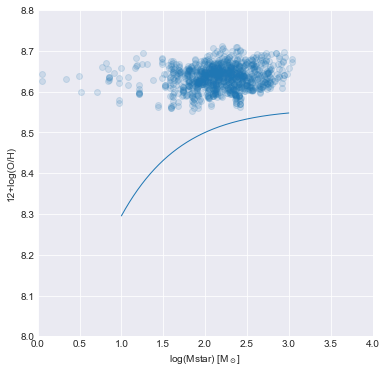

The spaxels in our galaxy are typically above the best fit relation.  Part of the offset may be due to systematic differences in the metallicity calibrator used, but the overal trend of flat metallicity as stellar mass surface densities decreases seems to be in tension with their best fit.  It would be worth investigating this effect for more galaxies to understand if individual galaxies typically obey the best fit relation or whether they typically exhibit a flat trend in this space.


Ultimately, Barrera-Ballesteros et al. (2016) concluded that the spatially-resolved MZR is a scaled version of the global MZR (e.g., see Tremonti et al. 2004).